<a href="https://colab.research.google.com/github/beatrizalbiero/NLPNeuronWorkshop/blob/master/IMDB_Analise_de_Sentimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Bootcamp Neuron 2020

\\

**Autora**: Beatriz Albiero 

**Bio**: Possui graduação em Estatística e mestrado em Linguística Computacional (ambos pela USP). No mercado, atua como cientista de dados tendo participado de projetos diversos como: detecção de fraude, desenvolvimento de scores de crédito, estudos não supervisionados de análise de diálogos e construção de agentes conversacionais. Se interessa especialmente pelo desenvolvimento responsável de modelos de IA.

**Linkedin**: https://www.linkedin.com/in/beatriz-albiero/

**E-mail**: beatrizalbiero1@gmail.com:

\\



# Overview NLP

- É um ramo dentro do machine learning voltado para as tarefas que contém **texto** como features de interesse

- Detecção de fraudes em email

- Clusterização de tweets, diálogos, etc

- Agentes conversacionais

# Análise de Sentimentos


Neste case vamos falar sobre uma área dentro de NLP conhecida como Análise de Sentimento.  É uma tarefa bastante comum, principalmente na área de marketing. A ideia é basicamente tentar extrair a partir de um texto o "sentimento" da pessoa que o escreveu. Essencialmente, podemos considerar um sentimento como sento positivo ou negativo. Porém, é claro que existe muito mais nuance do que isso. É comum também trabalharem com sentimentos negativos, positivos e neutros.

A tarefa de análise de sentimento é (normalmente) considerada uma tarefa de classificação de texto. Procura-se identificar nas frases, palavras como "bom", "ótimo", "gostei", para classificar um comentário como positivo. Entretanto, essa tarefa pode ser bem complicada. Considere as frases abaixo:

- "não gostei desse filme"
- "seria ótimo se não tivessem estragado tudo no final"
- "até que foi bom, mas deixou algumas coisas a desejar"

Existem muitas formas de atacar esse problema. Aqui vão algumas referências:


- [Speech and Language Processing - D. Jurafsky and J. Martin](https://web.stanford.edu/~jurafsky/slp3/4.pdf)

- [Natural Language Processing with Python - Steven Bird](https://www.nltk.org/book/)

- [Foundations of Statistical Natural Language Processing - C. Manning](https://nlp.stanford.edu/fsnlp/)

# Problema

Vamos trabalhar com um dataset do IMDB com reviews de filmes. O dataset é composto por várias sentenças que são comentários sobre filmes e marcações de negativo (0) ou positivo (1). O dataset é equilibrado para os targets. 

# Imports

In [1]:
!pip install mglearn==0.1.9

     |████████████████████████████████| 542kB 2.8MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=f16dd797a601f3359fec83d9798c34c951b810765f5d967dd6426e4076fa3809
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn


In [2]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mglearn
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Download e Preparação dos Dados

In [3]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2020-09-09 18:03:02--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  21.9MB/s    in 4.6s    

2020-09-09 18:03:07 (17.4 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [4]:
! tar -xf aclImdb_v1.tar.gz

In [5]:
reviews_train = load_files("aclImdb/train/")
# load_files returns a bunch, containing training texts and training labels 
text_train, y_train = reviews_train.data, reviews_train.target
print("Tipo da variável text_train: {}".format(type(text_train)))
print("Tamanho text_train: {}".format(len(text_train))) 
print("text_train[1]:\n{}".format(text_train[1]))

Tipo da variável text_train: <class 'list'>
Tamanho text_train: 75000
text_train[1]:
b"Amount of disappointment I am getting these days seeing movies like Partner, Jhoom Barabar and now, Heyy Babyy is gonna end my habit of seeing first day shows.<br /><br />The movie is an utter disappointment because it had the potential to become a laugh riot only if the d\xc3\xa9butant director, Sajid Khan hadn't tried too many things. Only saving grace in the movie were the last thirty minutes, which were seriously funny elsewhere the movie fails miserably. First half was desperately been tried to look funny but wasn't. Next 45 minutes were emotional and looked totally artificial and illogical.<br /><br />OK, when you are out for a movie like this you don't expect much logic but all the flaws tend to appear when you don't enjoy the movie and thats the case with Heyy Babyy. Acting is good but thats not enough to keep one interested.<br /><br />For the positives, you can take hot actresses, last 30 m

In [6]:
reviews_test = load_files("aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target 

# Limpeza dos Dados

Sempre que trabalhamos com dados de texto, é importante passarmos pela etapa de **limpeza**. 

Você viu que acima, o nosso objetivo será transformar os documentos em vetores. Veja abaixo algumas etapas de limpeza importantes:

## Remoção de Stopwords

Stopwords é a denominação de palavras "semanticamente vazias", ou seja, palavras como preposições (de, da, para, como), pronomes (ele, eu), artigos (o, a), etc...
São palavras que aparecem demais nos textos e não precisam fazer parte do vocabulário pois dificilmente impactariam no algoritmo de classificação. 

**CUIDADO**


Remover stopwords em casos de análise de sentimentos pode enganar o seu modelo!

Verifique se a palavra "não" encontra-se na sua lista de stopwords.

Se removermos "não", podemos transformar "não gostei" em "gostei".

## Stemming e Lemmatização

É um método que consiste em cortar as palavras de modo a concentrar diversas palavras em uma única representação no vocabulário, ou seja, **grand**ioso e **grand**e, seriam ambas representadas por apenas **grand**. Fazer isso economiza memória e tempo para os nossos algoritmos.

Qual a diferença entre stemming e lemmatização?

Stemming: método computacional que funciona a partir de regrinhas básicas. Prático, porém...

**was -> wa**

Lemmatização: um sistema verificado por humanos.

**was -> be**

## Remoção de Pontuação e strings de codificação 

É importante removermos "lixinhos", itens no texto que não serão relevantes para a classificação. Pode haver também alguns caracteres ou marcadores de texto irrelevantes para a análise, como por exemplo "\s", "\n, etc.

In [7]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train] 

In [8]:
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

In [9]:
text_train[1]

b"Amount of disappointment I am getting these days seeing movies like Partner, Jhoom Barabar and now, Heyy Babyy is gonna end my habit of seeing first day shows.  The movie is an utter disappointment because it had the potential to become a laugh riot only if the d\xc3\xa9butant director, Sajid Khan hadn't tried too many things. Only saving grace in the movie were the last thirty minutes, which were seriously funny elsewhere the movie fails miserably. First half was desperately been tried to look funny but wasn't. Next 45 minutes were emotional and looked totally artificial and illogical.  OK, when you are out for a movie like this you don't expect much logic but all the flaws tend to appear when you don't enjoy the movie and thats the case with Heyy Babyy. Acting is good but thats not enough to keep one interested.  For the positives, you can take hot actresses, last 30 minutes, some comic scenes, good acting by the lead cast and the baby. Only problem is that these things do not come

# Contagem do Target

In [10]:
print("Treino: {}".format(np.bincount(y_train)))
print("Teste: {}".format(np.bincount(y_test))) 

Treino: [12500 12500 50000]
Teste: [12500 12500]


In [11]:
pd.Series(y_train).value_counts()

2    50000
1    12500
0    12500
dtype: int64

In [12]:
preprocess = pd.concat([pd.Series(text_train), pd.Series(y_train)], axis=1)
preprocess = preprocess[preprocess[1] != 2]
text_train = preprocess[0]
y_train = np.array(preprocess[1])

In [13]:
pd.Series(y_train).value_counts()

1    12500
0    12500
dtype: int64

In [14]:
pd.Series(y_test).value_counts()

1    12500
0    12500
dtype: int64

In [15]:
y_test[1]

0

In [16]:
text_train.isna().any()

False

# Representação Numérica das Palavras

Para alimentarmos os nossos modelos de ML, será necessário transformar os textos em representações que os modelos compreendam, ou seja, vetores numéricos.

## Bag of Words

A técnica de Bag of Words é chamada assim por considerarmos o texto como um "saco de palavras". Não é importante a ordem das palavras ou o significado. Teremos uma representação vetorial para cada palavra do vocabulário.

Vocabulário: Conjunto de todas as palavras únicas de um texto.

O cálculo da representação do Bag-of-Words para um corpus de documentos consiste nas três etapas a seguir:
1. Tokenização. Divisão do texto através das palavras que aparecem nele (chamadas de tokens), por exemplo, dividindo-o em espaços em branco e pontuação.
2. Construção de vocabulário. Obtenha um vocabulário de todas as palavras que aparecem em qualquer um dos documentos e numere-as (digamos, em ordem alfabética).
3. Codificação. Para cada documento, conte quantas vezes cada uma das palavras do vocabulário aparece neste documento.

## Exemplo:

![bow](https://drive.google.com/uc?export=view&id=1nvfzqX6PD-OxJCO-aa-QdmWOQKgfvpGN)

# TF IDF

Outra abordagem possível é redimensionar os vetores de acordo com o quão **informativos** esperamos que sejam. Uma forma de fazer isso é através da técnica TF-IDF. 

O que é TF-IDF?

**term frequency–inverse document frequency**

[Artigo no Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

A intuição desse método é dar um peso maior aos termos que aparecem com maior frequência em um determinado documento, mas não em muitos documentos do corpus. Se uma palavra aparece com freqüência em um determinado documento, mas não em muitos documentos, é provável que seja muito descritiva do conteúdo desse documento.

Mas o que é um **documento**?

Em NLP, um "documento" é um texto distinto. Isso geralmente significa que cada artigo, livro ou assim por diante é seu próprio documento. Se você quiser, pode tratar um parágrafo individual ou mesmo uma frase como um "documento".

- Term-frequency = Quantas vezes um termo (palavra, stem) aparece em um documento.

- Document-frequency = Quantas vezes um termo aparece no conjunto de todos os documentos.

- Inverse Document-frequency = 1/DF 

- TF-IDF: TF * 1/DF = TF/DF

Os pesos dos termos são atribuídos da seguinte forma:

![](https://drive.google.com/uc?export=view&id=1S_LaVTT2EvwaS6MqsfMvLiWBUSjxhEsw)

onde N é o número de documentos no conjunto de treinamento, Nw é o número de documentos no conjunto de treinamento em que a palavra w aparece e tf (term frequency) é o número de vezes que a palavra w aparece no documento de consulta d (o documento que você deseja transformar ou codificar).

Por que log?

Porque como se trata de uma contagem podemos eventualmente estar falando milhares, milhões. Quando tomamos o log, damos uma suavizada na contagem e portanto menos peso a palavras muito comuns.

Por que adicionar 1?

Porque se Nw = 0, log(0) = -inf e log(1) = 0.

No nosso caso, vamos considerar cada **review**, ou seja, cada frase, um documento. Assim saberemos quais a palavras que mais se destacam em cada documento e quais aquelas que aparecem mais frequentemente em comentários negativos/positivos.

## Na prática...

In [26]:
sample = text_train[:20]

In [62]:
sample

3     b"Dan Katzir has produced a wonderful film tha...
4     b'If you want Scream or anything like the big-...
9     b"Outlandish premise that rates low on plausib...
11    b'Let\'s face it-- if you rented a STDVD seque...
12    b'Bizarre Tobe Hooper exercise regarding an un...
13    b'Well, maybe the PC version of this game was ...
16    b'Watching "Kroko" I would have liked to leave...
17    b"First of all, I have to start this comment b...
18    b"Very much a film from the times -- extremely...
23    b'"The Invisible Ray" is part science fiction ...
28    b"Rosenstrasse is a touching story of courage ...
29    b'Nell Shipman must have been paid a hefty sum...
30    b'One of the best parts of Sundance is seeing ...
32    b"Don't bother trying to watch this terrible m...
37    b"I am not a parent, neither am I a male. But ...
39    b'This is mostly a story about the growing rel...
41    b'it\'s a weekend i\'ve been watched this funn...
43    b"This film tells the story of a romance b

In [33]:
set(str(sample[3]).split(' '))

{'',
 '-',
 "Dan's",
 'For',
 'If',
 'Instantly,',
 'Iris,',
 'Israel',
 'Israel.',
 'Katzir',
 'The',
 'You',
 'a',
 'an',
 'and',
 'anyone',
 'are',
 'at',
 'atmosphere',
 'b"Dan',
 'back',
 'be',
 'been',
 'between',
 'bitter-sweet.',
 'brings',
 'came',
 "can't",
 'contrast',
 'deeply',
 'desperate,',
 'difficult',
 'drama',
 'drawn',
 'eminently',
 'ever',
 'fail',
 'fear',
 'feeling.',
 'film',
 'film."',
 'has',
 'have',
 'heartache',
 'in',
 'insecurities',
 'intensify',
 'isolation',
 'just',
 'like',
 'love',
 'love,',
 'make',
 'modern',
 'moved.',
 'of',
 'on',
 'ounce',
 'passion',
 'passion,',
 'plight,',
 'produced',
 'real',
 'realities',
 'relationship',
 'ride',
 'roller-coaster',
 'romance',
 'see',
 'serve',
 'set',
 'snatched',
 'so',
 'state',
 'surrounding',
 'takes',
 'that',
 'the',
 'this',
 'through',
 'time',
 'times',
 'to',
 'troubles',
 'turmoil',
 'uncertainties,',
 'us',
 'watchable.',
 "who's",
 'with',
 'wonderful',
 'write',
 'you'}

In [36]:
vocab = list()
for item in sample:
  words = str(item).split(' ')
  vocab = vocab + words

vocab = set(vocab)

In [38]:
len(vocab)

2303

In [17]:
tfidf = TfidfVectorizer(min_df=5)

In [39]:
example_tfidf = tfidf.fit_transform(text_train[:20])

In [40]:
example_tfidf

<20x113 sparse matrix of type '<class 'numpy.float64'>'
	with 943 stored elements in Compressed Sparse Row format>

In [24]:
example_tfidf.shape

(20, 113)

# Pipeline

Vamos utilizar a classe Pipeline do Scikit Learn para transformarmos as nossas reviews em vetores de TF-IDF e em seguida fitarmos um modelo de regressão logística nas nossas novas "features". 

A função de TfidfVectorizer do scikit já possui algumas limpezas implementadas dentro dela. Ela remove pontuações e "normaliza" o texto, transformando todas as letras em minúsculas.

Também é possível passar uma lista de stop words para ela remover!

In [48]:
pipe = make_pipeline(TfidfVectorizer(min_df=5),
                     LogisticRegression(penalty='l1', solver='liblinear'))

In [49]:
 param_grid = {'logisticregression__C': [0.001, 0.01],#, 0.1, 1, 10]}
               'logisticregression__random_state': [0]}

In [50]:
grid = GridSearchCV(pipe, param_grid, scoring='neg_log_loss', cv=3)
grid.fit(text_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=5,
                                                        ngram_range=(1, 1),
                                               

In [51]:
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: -0.69


In [52]:
print("Best parameters: ", grid.best_params_)

Best parameters:  {'logisticregression__C': 0.001, 'logisticregression__random_state': 0}


In [53]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"] # transform the training dataset
X_train = vectorizer.transform(text_train)
# find maximum value for each of the features over the dataset 
max_value = X_train.max(axis=0).toarray().ravel() 
sorted_by_tfidf = max_value.argsort() # get feature names (indexes)
feature_names = np.array(vectorizer.get_feature_names()) 

print("Features with lowest tfidf:\n{}".format(
feature_names[sorted_by_tfidf[:20]])) 

print("Features with highest tfidf: \n{}".format(
feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['suplexes' 'gauche' 'hypocrites' 'oncoming' 'songwriting' 'galadriel'
 'emerald' 'mclaughlin' 'sylvain' 'oversee' 'cataclysmic' 'pressuring'
 'uphold' 'thieving' 'inconsiderate' 'ware' 'denim' 'reverting' 'booed'
 'spacious']
Features with highest tfidf: 
['gadget' 'sucks' 'zatoichi' 'demons' 'lennon' 'bye' 'dev' 'weller'
 'sasquatch' 'botched' 'xica' 'darkman' 'woo' 'casper' 'doodlebops'
 'smallville' 'wei' 'scanners' 'steve' 'pokemon']


In [58]:
max_value

array([0.39314587, 0.32476869, 0.33912267, ..., 0.43735711, 0.41781736,
       0.14005376])

In [57]:
sorted_by_tfidf

array([23668, 10103, 11968, ..., 21090, 23134, 18303])

Termos com baixo tf–idf são aqueles que são muito comumente usados ​​em documentos, ou são usados raramente ou em documentos muito longos. Curiosamente, muitos dos termos com alto tf–idf realmente identificam certos programas ou filmes. Esses termos aparecem apenas em resenhas para este programa ou franquia específico, mas tendem a aparecer com muita frequência nessas resenhas específicas. Isso é muito claro, por exemplo, para "pokemon", "smallville" e "doodlebops". É improvável que essas palavras nos ajudem em nossa tarefa de classificação de sentimento (a menos que algumas franquias sejam universalmente revisadas como positivas ou negativas).

# Coeficientes do modelo

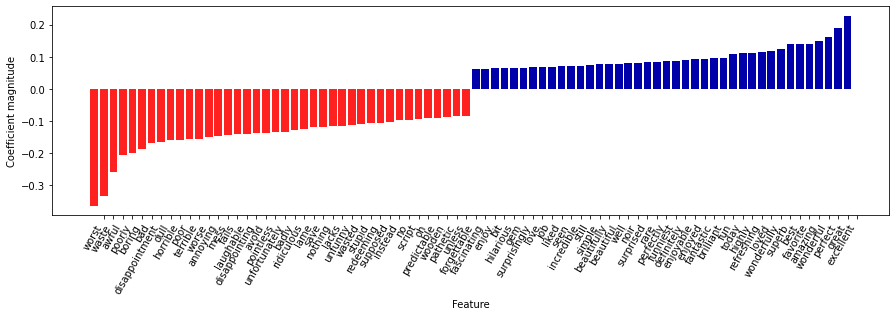

In [23]:
mglearn.tools.visualize_coefficients(
        grid.best_estimator_.named_steps["logisticregression"].coef_,
        feature_names, n_top_features=40)

In [59]:
predictions = grid.predict(text_test)

In [60]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [61]:
predict_probas = grid.predict_proba(text_test)

# Avaliação do nosso modelo

In [27]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.86      0.89      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [33]:
cf_matrix = confusion_matrix(y_test, predictions)

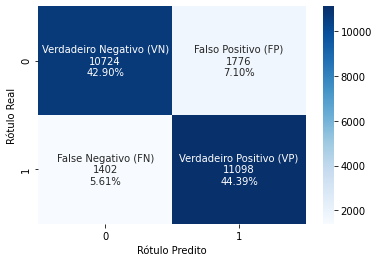

In [36]:
group_names = ['Verdadeiro Negativo (VN)','Falso Positivo (FP)','False Negativo (FN)','Verdadeiro Positivo (VP)']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Rótulo Predito")
plt.ylabel("Rótulo Real")
plt.show()

# Referência:

[Introduction to Machine Learning with Python: A Guide for Data Scientists](https://www.amazon.com.br/Introduction-Machine-Learning-Andreas-Mueller/dp/1449369413),

Andreas C. Müller, Sarah Guido

![](https://drive.google.com/uc?export=view&id=1GBafNzJQziEpaMIpluFpK6xH4-nsb_yr)